In [1]:
from get_data import GetData
from multi_objective import MultiObjective
from methods import NavieMethod
# import matplotlib.pyplot as plt
# import numpy as np
from ml_header import *
%matplotlib inline

import logging
logging.basicConfig(filename='all.log',
                    format='%(asctime)s %(levelname)s: %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S', level=logging.DEBUG)

In [2]:
gd = GetData()
gd.main()

In [3]:
benchmarks_valid = ['average', 'fir', 'kasumi', 'snow3g', 'sobel']

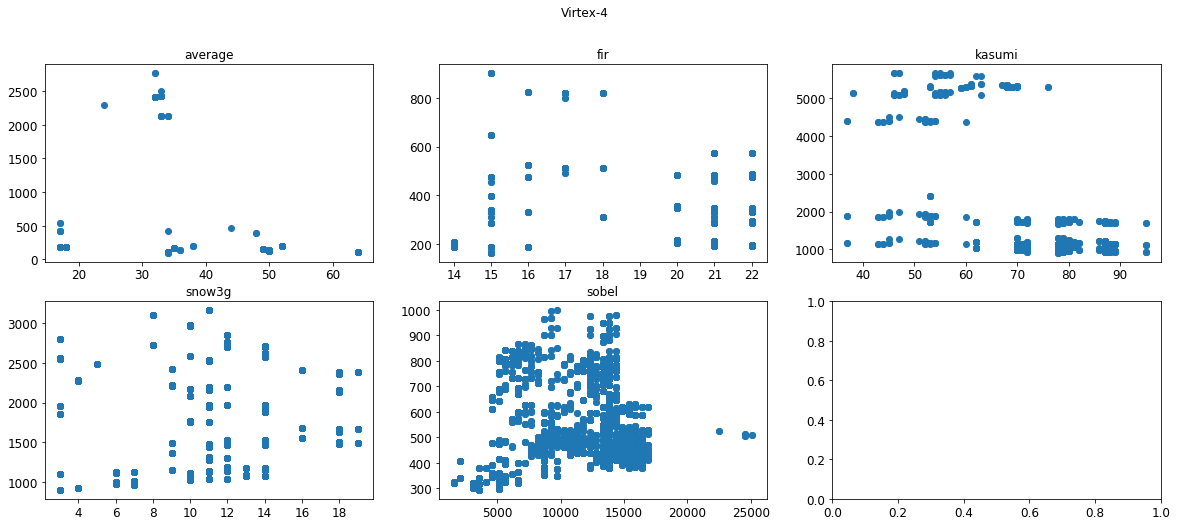

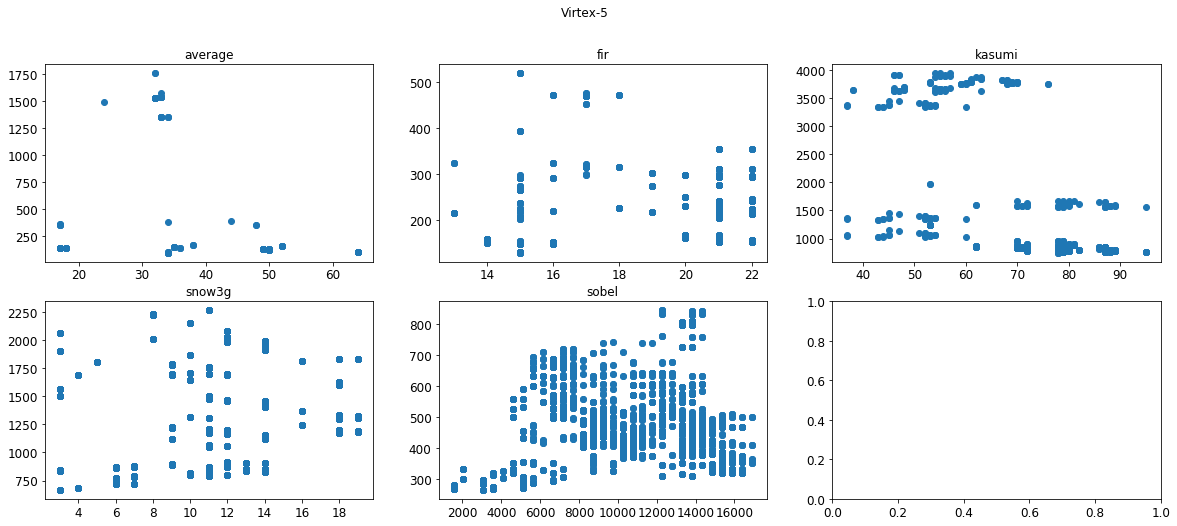

In [4]:
# Observe Latency vs Area
fig_4, axes_4 = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
fig_5, axes_5 = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
benchmarks_valid = ['average', 'fir', 'kasumi', 'snow3g', 'sobel']
for i, v in enumerate(benchmarks_valid):
    df_v4 = gd.data_v4[v]
    df_v5 = gd.data_v5[v]
    axes_4[i//3, i%3].scatter(df_v4['Latency'].values, df_v4['fpga_area'].values)
#     df_v4.plot(kind='scatter', x='Latency', y='fpga_area', alpha=0.2, ax=axes_4[i//3, i%3])
    axes_4[i//3, i%3].set_title(v)
    axes_5[i//3, i%3].scatter(df_v5['Latency'].values, df_v5['fpga_area'].values)
    axes_5[i//3, i%3].set_title(v)
fig_4.suptitle('Virtex-4')
fig_5.suptitle('Virtex-5')
plt.show()

In [ ]:
# Observe the histogram of the attributes
for i, v in enumerate(benchmarks_valid):
    df_v4 = gd.data_v4[v]
    df_v5 = gd.data_v5[v]
    df_v4.hist(bins=50, figsize=(20, 15))
    df_v5.hist(bins=50, figsize=(20, 15))

In [ ]:
# Correlations
for i, v in enumerate(benchmarks_valid):
    print('='*20, v)
    df_v4 = gd.data_v4[v]
    df_v5 = gd.data_v5[v]
    print(df_v4.corr()['fpga_area'].sort_values(ascending=False))
    print(df_v5.corr()['fpga_area'].sort_values(ascending=False))

In [5]:
# Select promising features and the target
attributes = ['fpga_area', 'MUX', 'Pin_Pair', 'MISC', 'Net', 'DEC']

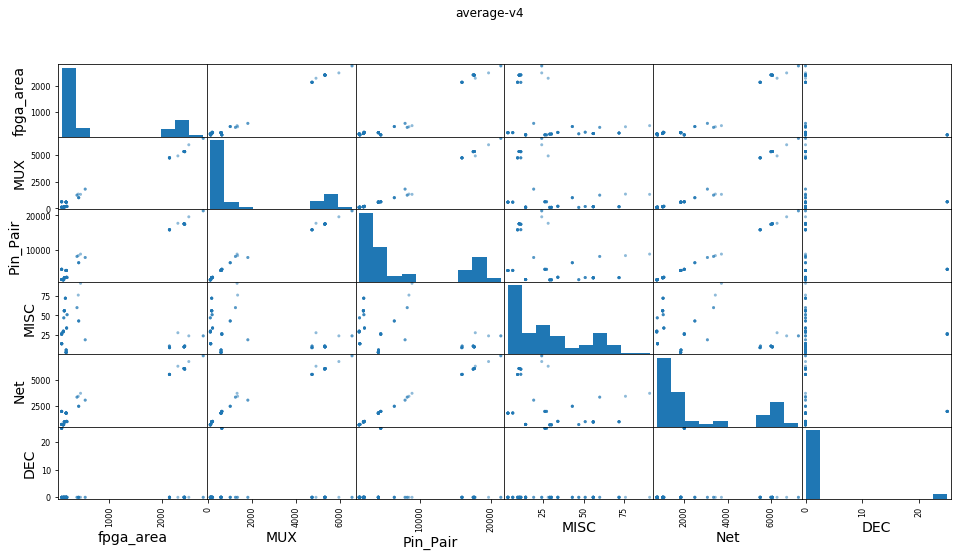

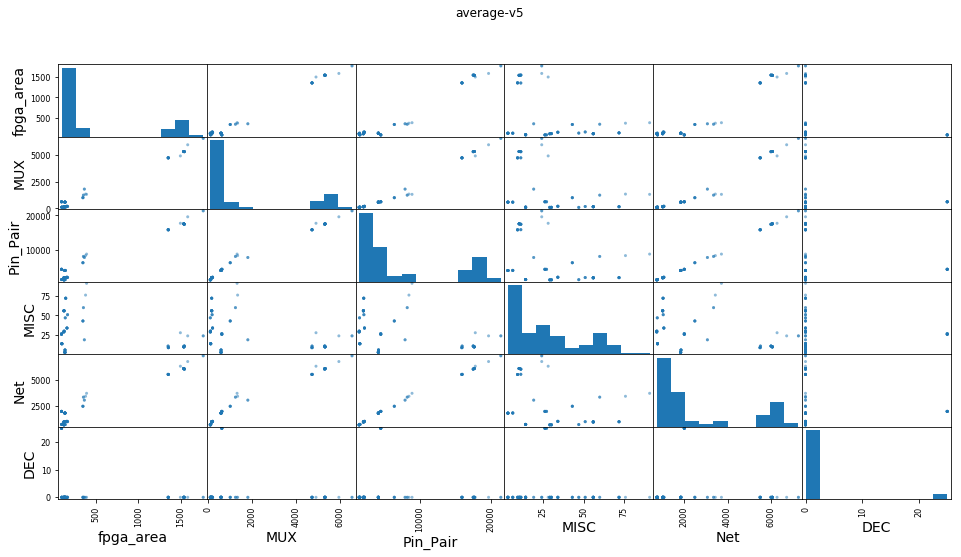

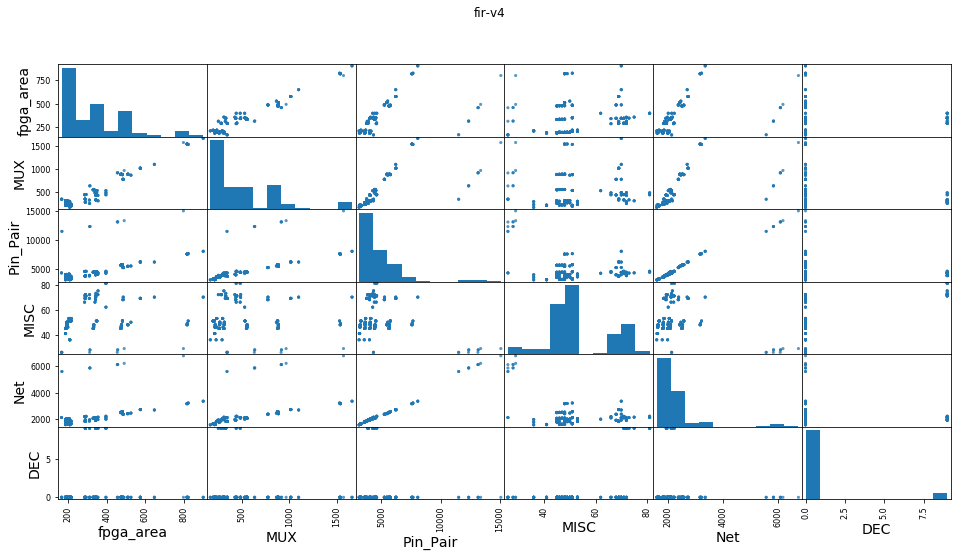

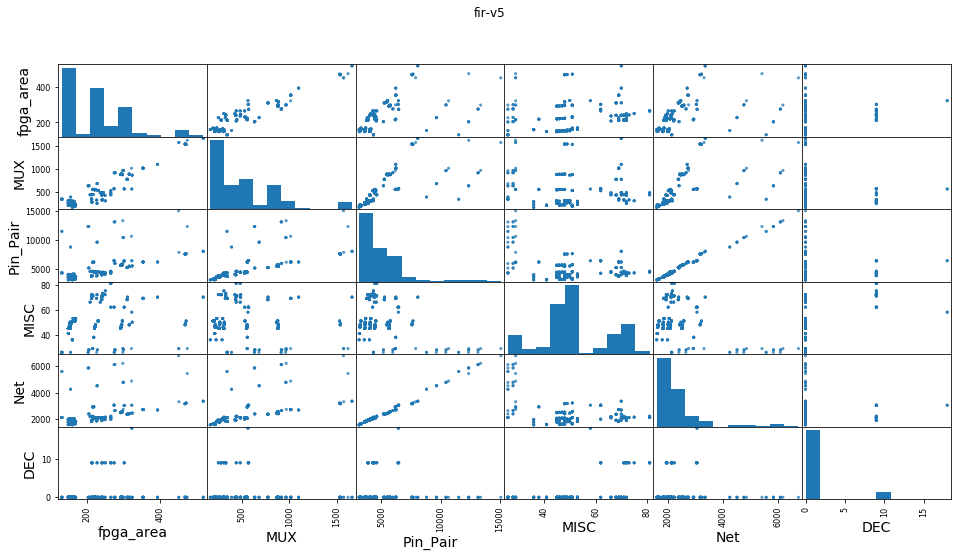

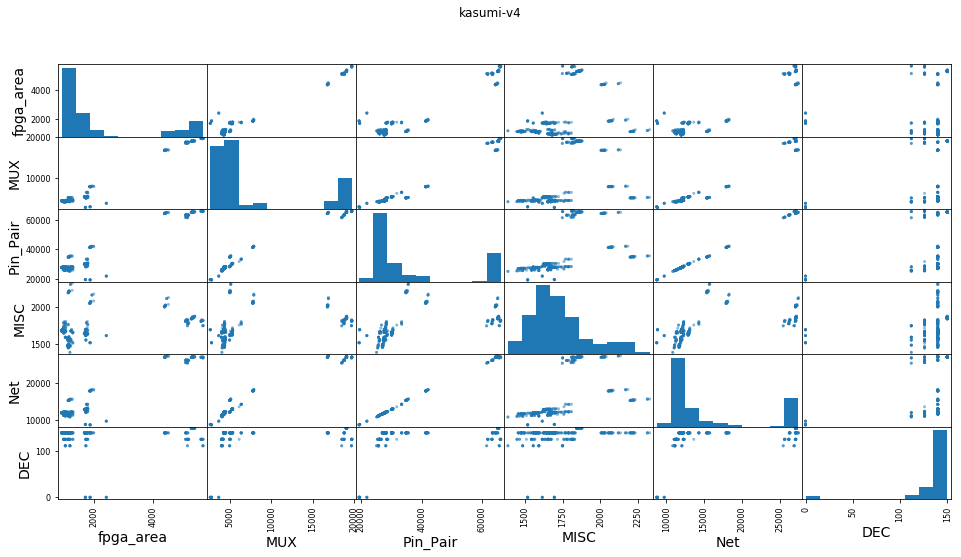

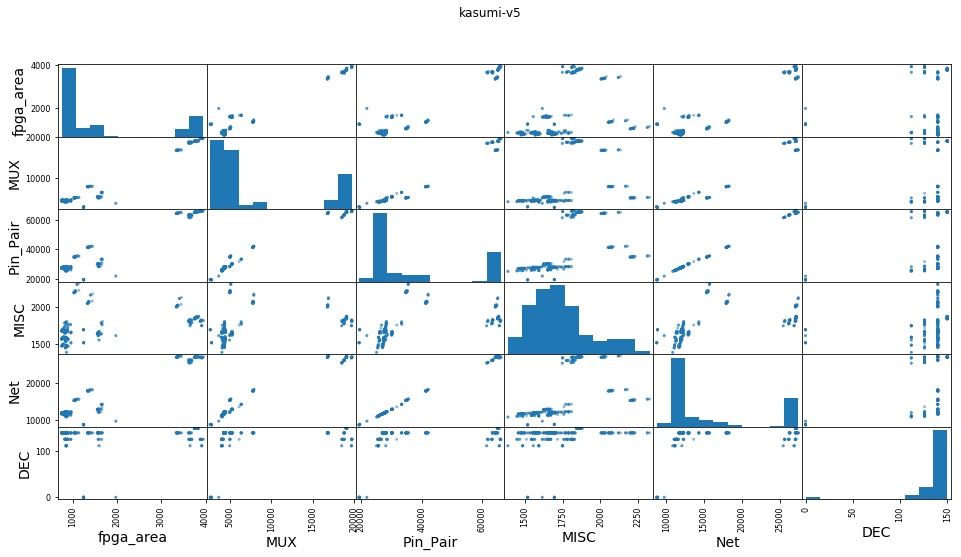

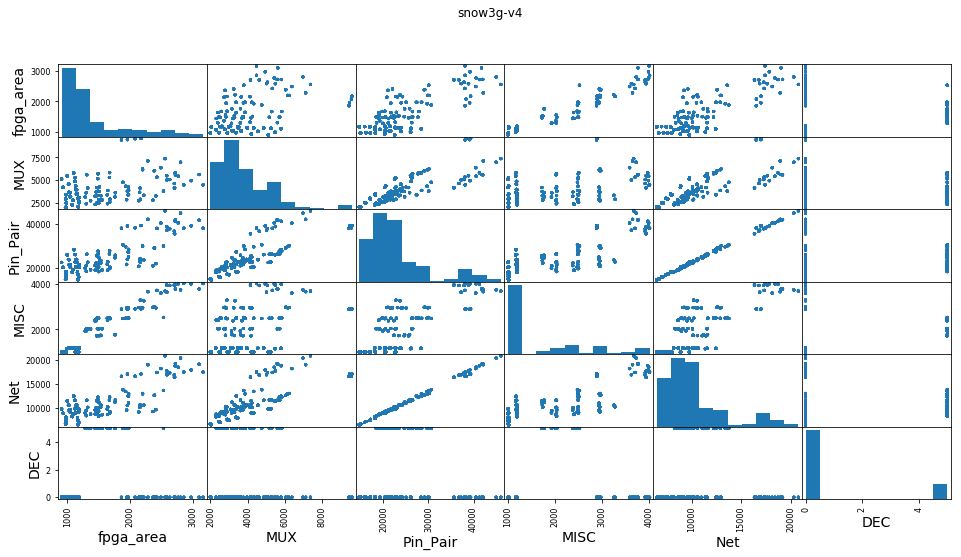

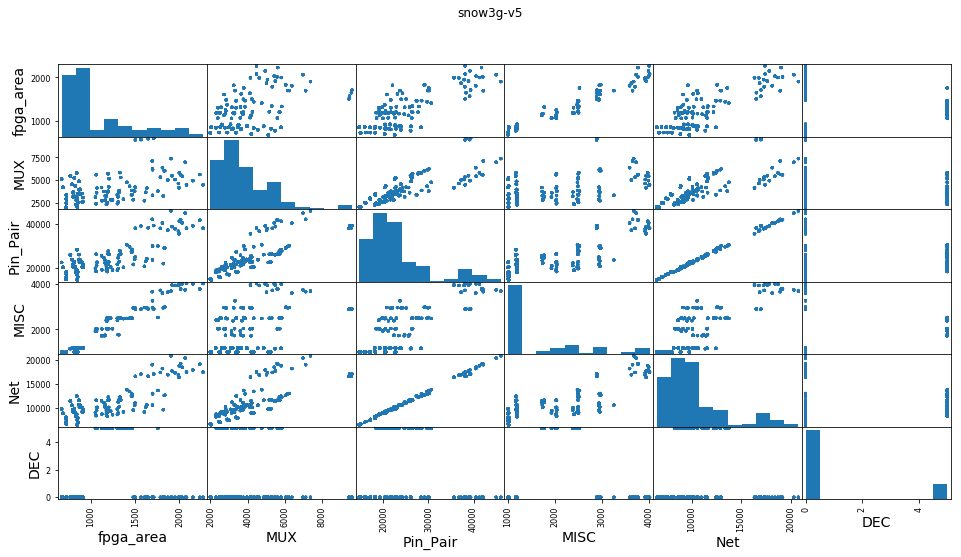

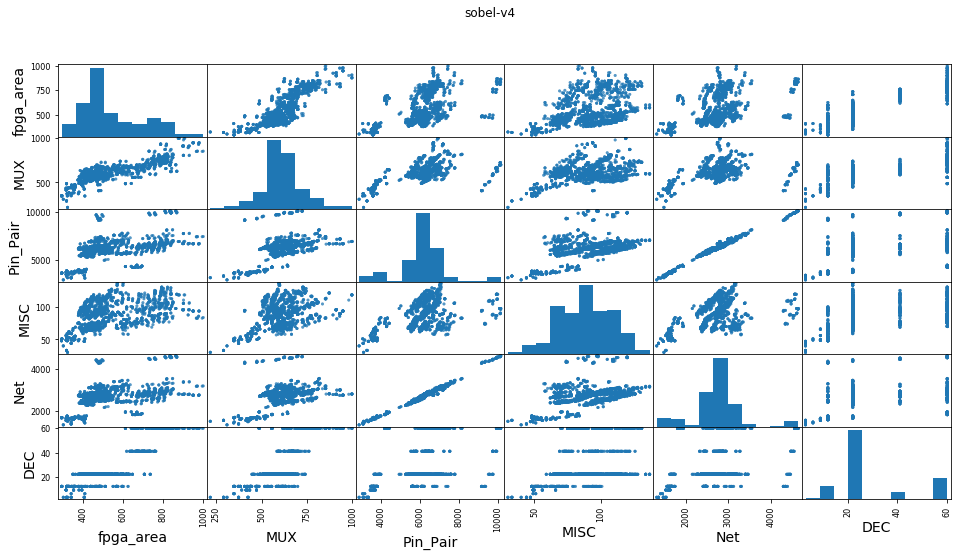

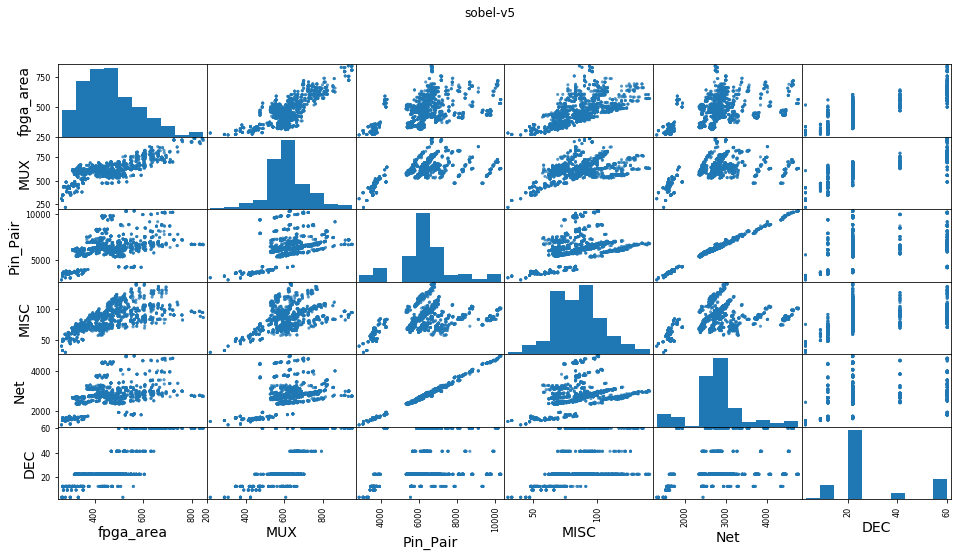

In [6]:
# Correlations of promising attributes
from pandas.plotting import scatter_matrix
for i, v in enumerate(benchmarks_valid):
    df_v4 = gd.data_v4[v]
    df_v5 = gd.data_v5[v]
    scatter_matrix(df_v4[attributes], figsize=(16,8))
    plt.suptitle(v + '-v4')
    scatter_matrix(df_v5[attributes], figsize=(16,8))
    plt.suptitle(v + '-v5')

In [7]:
# Data for Machine Learning
data_v4_x, data_v4_y = {}, {}
data_v5_x, data_v5_y = {}, {}
for i, v in enumerate(benchmarks_valid):
    df_v4 = gd.data_v4[v][attributes]
    df_v5 = gd.data_v5[v][attributes]
    data_v4_x[v] = df_v4.drop('fpga_area', axis=1)
    data_v4_y[v] = df_v4['fpga_area'].copy()
    data_v5_x[v] = df_v5.drop('fpga_area', axis=1)
    data_v5_y[v] = df_v5['fpga_area'].copy()

In [8]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_v4_x_scaled, data_v5_x_scaled = {}, {}
for i in benchmarks_valid:
    data_v4_x_scaled[i] = scaler.fit_transform(data_v4_x[i])
    data_v5_x_scaled[i] = scaler.fit_transform(data_v5_x[i])

In [9]:
# Normalized dataframe
df_v4_scaled, df_v5_scaled = {}, {}
for i in benchmarks_valid:
    df_v4_scaled[i] = pd.DataFrame(np.append(data_v4_y[i].values.reshape(-1, 1), data_v4_x_scaled[i], axis=1),
                                   columns=attributes)
    df_v5_scaled[i] = pd.DataFrame(np.append(data_v5_y[i].values.reshape(-1, 1), data_v5_x_scaled[i], axis=1),
                                   columns=attributes)

In [ ]:
# Select and train a model
bench = 'average'
from sklearn.linear_model import LinearRegression
lin_reg = RandomForestRegressor()
lin_reg.fit(data_v4_x_scaled[bench], data_v4_y[bench])
# lin_reg.fit(data_v5_x_scaled[bench], data_v5_y[bench])

navie = NavieMethod()
navie.df = gd.data_v4[bench].copy()
navie.df['AREA'] = lin_reg.predict(data_v4_x_scaled[bench])
# navie.df = gd.data_v5[bench].copy()
# navie.df['AREA'] = lin_reg.predict(data_v5_x_scaled[bench])

navie.main()

navie.visulize()
plt.show()

In [ ]:
print(navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms)
print(navie.hypervolume_ratio, navie.dominance, navie.cardinality)

# =====

In [10]:
def compare(m1, m2):
    better = 1
    for i in benchmarks_valid:
        better &= m1[i][0] <= m2[i][0] and m1[i][1] <= m2[i][1] \
              and m1[i][2] <= m2[i][2] and m1[i][3] <= m2[i][3] \
              and m1[i][4] >= m2[i][4] and m1[i][5] >= m2[i][5]
    return better

In [11]:
from itertools import combinations
results_partial_trained_v4 = {}
navie = NavieMethod()
# train_num = 1
for train_num in range(1, len(benchmarks_valid)):
    test_num = len(benchmarks_valid) - train_num
    bench_train = list(combinations(benchmarks_valid, train_num))
    model = RandomForestRegressor()
#     model = LinearRegression()
    for i in bench_train:
        bench_test = list(set(benchmarks_valid) - set(i))
        train_scaled = pd.concat([df_v4_scaled[m] for m in i]).reset_index(drop=True)
        print('='*20 + 'Trained model(s): {}'.format(i))
    #     logging.info('='*20 + 'Trained model(s): {}'.format(i))
        X = train_scaled.drop('fpga_area', axis=1)
        y = train_scaled['fpga_area'].copy()
        model.fit(X, y)

        results_partial_trained_v4[i] = {}

        for j in benchmarks_valid:
            navie.df = gd.data_v4[j].copy()
            navie.df['AREA'] = model.predict(df_v4_scaled[j].drop('fpga_area', axis=1))
            # navie.df = gd.data_v5[bench].copy()
            # navie.df['AREA'] = lin_reg.predict(data_v5_x_scaled[bench])

            navie.main()

            # nm.visulize()
            # plt.show()
#             print('=====', j)
#             print(navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms)
#             print(navie.hypervolume_ratio, navie.dominance, navie.cardinality)
            results_partial_trained_v4[i][j] = [navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms,
                                             navie.hypervolume_ratio, navie.dominance, navie.cardinality]

====================Trained model(s): ('average',)
====================Trained model(s): ('fir',)
====================Trained model(s): ('kasumi',)
====================Trained model(s): ('snow3g',)
====================Trained model(s): ('sobel',)
====================Trained model(s): ('average', 'fir')
====================Trained model(s): ('average', 'kasumi')
====================Trained model(s): ('average', 'snow3g')
====================Trained model(s): ('average', 'sobel')
====================Trained model(s): ('fir', 'kasumi')
====================Trained model(s): ('fir', 'snow3g')
====================Trained model(s): ('fir', 'sobel')
====================Trained model(s): ('kasumi', 'snow3g')
====================Trained model(s): ('kasumi', 'sobel')
====================Trained model(s): ('snow3g', 'sobel')
====================Trained model(s): ('average', 'fir', 'kasumi')
====================Trained model(s): ('average', 'fir', 'snow3g')
====================Trained model(s): ('a

In [12]:
from itertools import combinations
results_partial_trained_v5 = {}
navie = NavieMethod()
# train_num = 1
for train_num in range(1, len(benchmarks_valid)):
    test_num = len(benchmarks_valid) - train_num
    bench_train = list(combinations(benchmarks_valid, train_num))
    model = RandomForestRegressor()
#     model = LinearRegression()
    for i in bench_train:
        bench_test = list(set(benchmarks_valid) - set(i))
        train_scaled = pd.concat([df_v5_scaled[m] for m in i]).reset_index(drop=True)
        print('='*20 + 'Trained model(s): {}'.format(i))
    #     logging.info('='*20 + 'Trained model(s): {}'.format(i))
        X = train_scaled.drop('fpga_area', axis=1)
        y = train_scaled['fpga_area'].copy()
        model.fit(X, y)

        results_partial_trained_v5[i] = {}

        for j in benchmarks_valid:
            navie.df = gd.data_v5[j].copy()
            navie.df['AREA'] = model.predict(df_v5_scaled[j].drop('fpga_area', axis=1))
            # navie.df = gd.data_v5[bench].copy()
            # navie.df['AREA'] = lin_reg.predict(data_v5_x_scaled[bench])

            navie.main()

            # nm.visulize()
            # plt.show()
#             print('=====', j)
#             print(navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms)
#             print(navie.hypervolume_ratio, navie.dominance, navie.cardinality)
            results_partial_trained_v5[i][j] = [navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms,
                                             navie.hypervolume_ratio, navie.dominance, navie.cardinality]

====================Trained model(s): ('average',)
====================Trained model(s): ('fir',)
====================Trained model(s): ('kasumi',)
====================Trained model(s): ('snow3g',)
====================Trained model(s): ('sobel',)
====================Trained model(s): ('average', 'fir')
====================Trained model(s): ('average', 'kasumi')
====================Trained model(s): ('average', 'snow3g')
====================Trained model(s): ('average', 'sobel')
====================Trained model(s): ('fir', 'kasumi')
====================Trained model(s): ('fir', 'snow3g')
====================Trained model(s): ('fir', 'sobel')
====================Trained model(s): ('kasumi', 'snow3g')
====================Trained model(s): ('kasumi', 'sobel')
====================Trained model(s): ('snow3g', 'sobel')
====================Trained model(s): ('average', 'fir', 'kasumi')
====================Trained model(s): ('average', 'fir', 'snow3g')
====================Trained model(s): ('a

In [ ]:
train_v4_x, train_v4_y = {}, {}
test_v4_x,  test_v4_y  = {}, {}
train_v5_x, train_v5_y = {}, {}
test_v5_x,  test_v5_y  = {}, {}

In [ ]:
for i, v in enumerate(benchmarks_valid):
    bench_train = benchmarks_valid.copy()
    del(bench_train[i])
    # V4
    df_v4_train = pd.concat([df_v4_scaled[m] for m in bench_train]).reset_index(drop=True)
#     df_v4_train = pd.concat([gd.data_v4[m][attributes] for m in bench_train]).reset_index(drop=True)
    train_v4_x[v] = df_v4_train.drop('fpga_area', axis=1)
    train_v4_y[v] = df_v4_train['fpga_area'].copy()
    
    df_v4_test = df_v4_scaled[v]
    test_v4_x[v] = df_v4_test.drop('fpga_area', axis=1)
    test_v4_y[v] = df_v4_test['fpga_area'].copy()
    # V5
    df_v5_train = pd.concat([df_v5_scaled[m] for m in bench_train]).reset_index(drop=True)
    train_v5_x[v] = df_v5_train.drop('fpga_area', axis=1)
    train_v5_y[v] = df_v5_train['fpga_area'].copy()
    
    df_v5_test = df_v5_scaled[v]
    test_v5_x[v] = df_v5_test.drop('fpga_area', axis=1)
    test_v5_y[v] = df_v5_test['fpga_area'].copy()

In [ ]:
# Feature scaling
scaler = StandardScaler()
train_v4_x_scaled, test_v4_x_scaled = {}, {}
train_v5_x_scaled, test_v5_x_scaled = {}, {}
for i in benchmarks_valid:
    train_v4_x_scaled[i] = scaler.fit_transform(train_v4_x[i])
    test_v4_x_scaled[i] = scaler.fit_transform(test_v4_x[i])
    train_v5_x_scaled[i] = scaler.fit_transform(train_v5_x[i])
    test_v5_x_scaled[i] = scaler.fit_transform(test_v5_x[i])

In [ ]:
# Select and train a model
bench = 'snow3g'
lin_reg = RandomForestRegressor()
lin_reg.fit(train_v4_x_scaled[bench], train_v4_y[bench])
# lin_reg.fit(data_v5_x_scaled[bench], data_v5_y[bench])

In [ ]:
navie = NavieMethod()
print('Testing...')
lin_reg = RandomForestRegressor()
for bench in benchmarks_valid:
    lin_reg.fit(train_v4_x[bench], train_v4_y[bench])
    print('='*20)
    print('Not trained bench is: ', bench)
    for i in benchmarks_valid:
        navie.df = gd.data_v4[i].copy()
        navie.df['AREA'] = lin_reg.predict(test_v4_x[i])
        # navie.df = gd.data_v5[bench].copy()
        # navie.df['AREA'] = lin_reg.predict(data_v5_x_scaled[bench])

        navie.main()

        # nm.visulize()
        # plt.show()
        print('=====', i)
        print(navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms)
        print(navie.hypervolume_ratio, navie.dominance, navie.cardinality)

In [ ]:
navie = NavieMethod()
print('Testing...')
lin_reg = RandomForestRegressor()
for bench in benchmarks_valid:
    lin_reg.fit(train_v5_x[bench], train_v5_y[bench])
    print('='*20)
    print('Not trained bench is: ', bench)
    for i in benchmarks_valid:
        navie.df = gd.data_v5[i].copy()
        navie.df['AREA'] = lin_reg.predict(test_v5_x[i])
        # navie.df = gd.data_v5[bench].copy()
        # navie.df['AREA'] = lin_reg.predict(data_v5_x_scaled[bench])

        navie.main()

        # nm.visulize()
        # plt.show()
        print('=====', i)
        print(navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms)
        print(navie.hypervolume_ratio, navie.dominance, navie.cardinality)

In [14]:
# Navie method: reference
results_ref_v4, results_ref_v5 = {}, {}
navie = NavieMethod()
for i in benchmarks_valid:
    navie.df = gd.data_v4[i]
    navie.main()
    print('='*20, i, '-v4')
    print(navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms)
    print(navie.hypervolume_ratio, navie.dominance, navie.cardinality)
    results_ref_v4[i] = [navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms,
                         navie.hypervolume_ratio, navie.dominance, navie.cardinality]
for i in benchmarks_valid:
    navie.df = gd.data_v5[i]
    navie.main()
    print('='*20, i, '-v5')
    print(navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms)
    print(navie.hypervolume_ratio, navie.dominance, navie.cardinality)
    results_ref_v5[i] = [navie.adrs_ave, navie.adrs_ave_rms, navie.adrs_max, navie.adrs_max_rms,
                         navie.hypervolume_ratio, navie.dominance, navie.cardinality]

==================== average -v4
0.215 0.182176888732 0.43 0.364353777464
0.817239419467 0.5 4
==================== fir -v4
0.177671451356 0.177043341435 0.260606060606 0.259605978584
0.800289312457 0.0 1
==================== kasumi -v4
0.112239180905 0.113538485269 0.239344262295 0.241505699836
0.722947068424 0.3333333333333333 3
==================== snow3g -v4
0.0 0.0 0.0 0.0
0.30299492276 1.0 5
==================== sobel -v4
0.0154287420297 0.0485155511406 0.030612244898 0.1423614425
0.755241974227 0.3333333333333333 3
==================== average -v5
0.20202020202 0.166636241937 0.40404040404 0.333272483874
0.435263315721 0.5 4
==================== fir -v5
0.0998907444982 0.0993166000582 0.232558139535 0.231130015007
0.826716370066 0.3333333333333333 2
==================== kasumi -v5
0.186079686768 0.186737231642 0.365333333333 0.366326045447
0.62459414007 0.3333333333333333 3
==================== snow3g -v5
0.0 0.0 0.0 0.0
0.298904612076 1.0 5
==================== sobel -v5
0.0223

In [16]:
compare(results_partial_trained_v4[('fir',)], results_ref_v4)

0

In [15]:
for i, v in results_partial_trained_v4.items():
    if compare(v, results_ref_v4):
        print(i)

('kasumi', 'sobel')
('average', 'fir', 'kasumi', 'sobel')
('average', 'kasumi', 'snow3g', 'sobel')


In [16]:
results_partial_trained_v4[('kasumi', 'sobel')]

{'average': [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 3],
 'fir': [0.027113237639553429,
  0.027031428466506347,
  0.042105263157894736,
  0.041991424127343559,
  0.98636355607369341,
  0.0,
  2],
 'kasumi': [0.0012750455373406193,
  0.0012704378437044164,
  0.0076502732240437158,
  0.0076226270622264981,
  0.99603910666661233,
  0.8333333333333334,
  6],
 'snow3g': [0.0, 0.0, 0.0, 0.0, 0.31599344898793624, 1.0, 11],
 'sobel': [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 3]}

In [17]:
for i, v in results_partial_trained_v5.items():
    if compare(v, results_ref_v5):
        print(i)

In [18]:
int('10', base=2)

2